# GUC K-nearest neighbor Classification

### Import packages and data set
#### Import the "Classified data" file 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
%matplotlib inline


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv("drive/MyDrive/Classified Data" , usecols=[i for i in range(1,12)])
df_np = df.to_numpy()

In [4]:
df.head()

,WTT,PTI,EQW,SBI,LQE,QWG,FDJ,PJF,HQE,NXJ,TARGET CLASS
0,0.913917,1.162073,0.567946,0.755464,0.780862,0.352608,0.759697,0.643798,0.879422,1.231409,1
1,0.635632,1.003722,0.535342,0.825645,0.924109,0.648450,0.675334,1.013546,0.621552,1.492702,0
2,0.721360,1.201493,0.921990,0.855595,1.526629,0.720781,1.626351,1.154483,0.957877,1.285597,0
3,1.234204,1.386726,0.653046,0.825624,1.142504,0.875128,1.409708,1.380003,1.522692,1.153093,1
4,1.279491,0.949750,0.627280,0.668976,1.232537,0.703727,1.115596,0.646691,1.463812,1.419167,1


### Scale the features using sklearn.preprocessing package

**Instantiate a scaler standardizing estimator**

In [5]:
scaler = StandardScaler()

**Fit the features data only to this estimator (leaving the TARGET CLASS column) and transform**

In [6]:
scaler.fit(df.drop('TARGET CLASS',axis=1))
scaled_features = scaler.transform(df.drop('TARGET CLASS',axis=1))

In [7]:
df_feat = pd.DataFrame(scaled_features,columns=df.columns[:-1])
df_feat.head()

,WTT,PTI,EQW,SBI,LQE,QWG,FDJ,PJF,HQE,NXJ
0,-0.123542,0.185907,-0.913431,0.319629,-1.033637,-2.308375,-0.798951,-1.482368,-0.949719,-0.643314
1,-1.084836,-0.430348,-1.025313,0.625388,-0.444847,-1.152706,-1.129797,-0.202240,-1.828051,0.636759
2,-0.788702,0.339318,0.301511,0.755873,2.031693,-0.870156,2.599818,0.285707,-0.682494,-0.377850
3,0.982841,1.060193,-0.621399,0.625299,0.452820,-0.267220,1.750208,1.066491,1.241325,-1.026987
4,1.139275,-0.640392,-0.709819,-0.057175,0.822886,-0.936773,0.596782,-1.472352,1.040772,0.276510


### Train/Test split, model fit and prediction

In [8]:
from sklearn.model_selection import train_test_split
X = df_feat
y = df['TARGET CLASS']
X_train, X_test, y_train, y_test = train_test_split(scaled_features,df['TARGET CLASS'],
                                                    test_size=0.50, random_state=101)

In [9]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=1)

In [10]:
pred = knn.predict(X_test)

### Evaluation of classification quality using Confusion Matrix

In [11]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, pred)
conf_matrix

array([[233,  17],
       [ 24, 226]])

***Print Misclassification error rate***

In [12]:
print(f"Test Error: {100*np.sum(y_test != pred)/y_test.shape[0]}% \nTest Accuracy: {100*np.sum(y_test == pred)/y_test.shape[0]}%")

Test Error: 8.2% 
Test Accuracy: 91.8%


# Choosing 'k' using cross validation error
#### Plot the error rate vs. K Value

In [13]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

X_train_val, X_test, y_train_val, y_test = train_test_split(scaled_features,df['TARGET CLASS'],
                                                    test_size=0.2, random_state=101)

boxplots = []
means = []
minmums = []
maximums = []
test_acc = []
for k in range (1 , 21):
  knn = KNeighborsClassifier(n_neighbors=k)
  cv = KFold(n_splits=4, random_state=1, shuffle=True)
  scores = cross_val_score(knn, X_train_val, y_train_val, scoring='accuracy', cv=cv, n_jobs=-1)
  # test_acc.append((knn.predict(X_test) == y_test)/y_test.shape[0])
  # boxplots.append(1 - scores)
  means.append(np.mean(1 - scores))
  minmums.append(np.min(1 - scores))
  maximums.append(np.max(1 - scores))

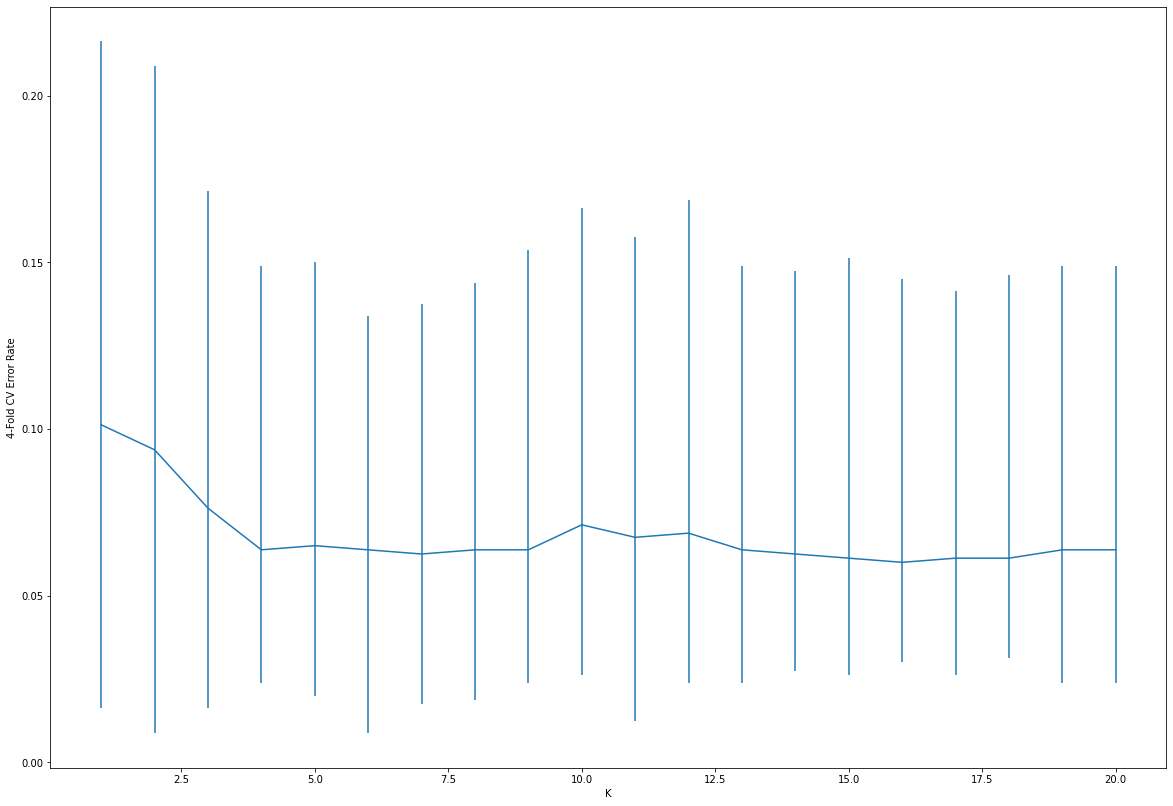

In [14]:
fig = plt.figure(figsize =(20, 14))
# plt.boxplot(boxplots)
# plt.plot(np.arange(1 , 21), means)
plt.errorbar(np.arange(1 , 21, 1), means, [minmums, maximums])
plt.xlabel("K")
plt.ylabel("4-Fold CV Error Rate")
plt.show()

In [15]:
means_scaled = means/np.max(means)
range_scaled = (np.array(maximums)-np.array(minmums))/np.max(np.array(maximums)-np.array(minmums))

best_k = np.argmin(means_scaled*range_scaled) + 1
best_accuracy = 1 - means[best_k - 1]
print(f"best K : {best_k}, Validation Accuracy : {best_accuracy}%")
print(f"test set accuracy: {100*np.sum(y_test == KNeighborsClassifier(n_neighbors=best_k).fit(X_train_val, y_train_val).predict(X_test))/y_test.shape[0]}")

best K : 6, Validation Accuracy : 0.93625%
test set accuracy: 93.5


**K = 6 is the K that gives the best error performance (low error mean and range). The validation set accuracy is estimated as 93.6% estimated by 4-fold cross validation estimator. The test set accuracy is estimated as 93.5%**